# Explainer Notebook
In addition to our website **[Car Collisions in New York City](http://socialdata.rasgaard.com/)**, we want to give the reader a look behind the scene and read about the considerations we made in regards to our project. We encourage the reader of this explainer notebook to hover plots seeing as they contain more information as well.

We will touch the following points:

* Motivation
* Basic Stats
* Data Analysis
* Genre
* Visualizations
* Discussion
* Contributions
* Reference List

But first we will load some dependencies.

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import time

# Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Plots
from IPython.display import HTML
import matplotlib.pyplot as plt; plt.style.use('seaborn')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_columns', None)

# Motivation

In the section below, we will give a short introduction to our topic and the selected dataset.

Our dataset is 'The Motor Vehicle Collisions' table which contains information from all police reported motor vehicle collisions in New York City (NYC), where each row represents a collision where *someone is injured or killed, or where there is at least \$1000 worth of damage*. The data is supplied by [NYC OpenData](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95). 

New York City is a vibrating and fast-moving city with over **8 million** citizens and *a lot* of traffic. We want to take a closer look into the collisions happening every day. Particularly of interest are those collisions that result in injuries or deaths. 

In 2014, the city-wide traffic safety initiative, [Vision Zero](https://www1.nyc.gov/content/visionzero/pages/), started. Their goal? To eliminate all traffic fatalities and serious injuries. By using data analysis and vizualizations, our goal is to look at when and where the probability of being injured or killed is highest, in order to work towards improving city traffic safety, and hopefully help reach Vision Zero's goal. The findings here will most likely be applicable to metropolises everywhere in the world. For further talks about the end user's experience, go to the **Genre** section of this notebook.

# Basic Stats

## Overview of Basic Stats
Basic Stats and Preprocessing takes up quite a lot due to the amount of code. For convenience, a overview is therefore included. Each subsection can be read independently. 

- **Preprocessing:**
    - **Preprocessing - Part 0: *Loading in the Data***
    - **Preprocessing - Part 1: *How Much Data is Missing?***
    - **Preprocessing - Part 2: *Cleaning up `LOCATION`, `LATITUDE` and `LONGITUDE`***
    - **Preprocessing - Part 3: *Cleaning up `BOROUGH` and `ZIP CODE`***
    - **Preprocessing - Part 4: *Encoding Contributing Factors***
    - **Preprocessing - Part 5: *Last Cleaning and Final Dataset***
    - **Preprocessing - *TL;DR***


- **Basic Stats:**
    - **Distribution across Borough**
    - **Contributing Factors**
    - **Temporal Distributions**

## Preprocessing - Part 0: *Loading in the Data*

First thing first, we will load the dataset. We only include data from 2013 to 2020 since 2012 and 2021 are incomplete.

In [2]:
df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv'); 
df = df.loc[df['CRASH DATE'].apply(lambda x : (int(x[-4:]) > 2012)&(int(x[-4:]) < 2021))] #Only keep data from 2013 to 2020.
print(f'The shape of the data: {df.shape}')
df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of the data: (1644188, 29)


CRASH DATE CRASH TIME BOROUGH ZIP CODE  LATITUDE  LONGITUDE LOCATION  \
13   09/21/2014      21:16     NaN      NaN       NaN        NaN      NaN   
193  12/31/2020      16:30     NaN      NaN       NaN        NaN      NaN   
194  12/31/2020      18:07   BRONX  10462.0       NaN        NaN      NaN   
195  12/31/2020       8:45     NaN      NaN       NaN        NaN      NaN   
196  12/29/2020      15:00     NaN      NaN       NaN        NaN      NaN   

                       ON STREET NAME   CROSS STREET NAME OFF STREET NAME  \
13                                NaN                 NaN             NaN   
193  BELT PARKWAY                                     NaN             NaN   
194  CROSS BRONX EXPRESSWAY            CASTLE HILL AVENUE             NaN   
195  LONG ISLAND EXPRESSWAY                           NaN             NaN   
196  20 AVENUE                             PATRACCA PLACE             NaN   

     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
13                         2.0                       0.0   
193                        0.0                       0.0   
194                        0.0                       0.0   
195                        0.0                       0.0   
196                        0.0                       0.0   

     NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
13                               0                             0   
193                              0                             0   
194                              0                             0   
195                              0                             0   
196                              0                             0   

     NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
13                           0                         0   
193                          0                         0   
194                          0                         0   
195                          0                         0   
196                          0                         0   

     NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  \
13                            2                          0   
193                           0                          0   
194                           0                          0   
195                           0                          0   
196                           0                          0   

      CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
13                 Backing Unsafely                   Unspecified   
193  Reaction to Uninvolved Vehicle                           NaN   
194                     Unspecified                   Unspecified   
195            Unsafe Lane Changing                   Unspecified   
196           Following Too Closely                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
13                            NaN                           NaN   
193                           NaN                           NaN   
194                           NaN                           NaN   
195                           NaN                           NaN   
196                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
13                            NaN       3123558   
193                           NaN       4380668   
194                           NaN       4380840   
195                           NaN       4380675   
196                           NaN       4380010   

                     VEHICLE TYPE CODE 1 VEHICLE TYPE CODE 2  \
13                     PASSENGER VEHICLE   PASSENGER VEHICLE   
193                                Sedan                 NaN   
194  Station Wagon/Sport Utility Vehicle               Sedan   
195                                Sedan           Box Truck   
196                                Sedan               Sedan   

    VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  

The columns can be divided into several categories:

- **Temporal**
    - `CRASH DATE`
    - `CRASH TIME`
    
    
- **Spatial**
    - `BOROUGH` which is the borough of the accident (Brooklyn, Bronx, Manhattan, Staten Island or Queens)
    - `ZIP CODE` 
    - `LATITUDE` and `LONGITUDE`
    - `ON STREET NAME`, `CROSS STREET NAME`, `OFF STREET NAME`
    
    
- **Contributing Factors**
    - `CONTRIBUTING FACTOR VEHICLE 1`, `CONTRIBUTING FACTOR VEHICLE 2`, ... , `CONTRIBUTING FACTOR VEHICLE 5`
    
    
- **Vehicle Types**
    - `VEHICLE TYPE CODE 1`, `VEHICLE TYPE CODE 2`, ... , `VEHICLE TYPE CODE 5`


- **Number of people injured or killed**
    - `NUMBER OF PERSONS INJURED`, which splits into `NUMBER OF PEDESTRIANS INJURED`, `NUMBER OF CYCLISTS INJURED` and `NUMBER OF MOTORIST INJURED`.
    - `NUMBER OF PERSONS KILLED`, which also splits into `NUMBER OF PEDESTRIANS KILLED`, `NUMBER OF CYCLISTS KILLED` and `NUMBER OF MOTORISTS KILLED`.

## Preprocessing - Part 1: *How Much Data is Missing?*

Before looking at how much data is missing, let us replace some nonsensical values with nan. 

In [3]:
df['LOCATION'] = df['LOCATION'].replace({'(0.0, 0.0)' : np.nan})
df['ZIP CODE'] = df['ZIP CODE'].replace({'     ' : np.nan}).astype(float)

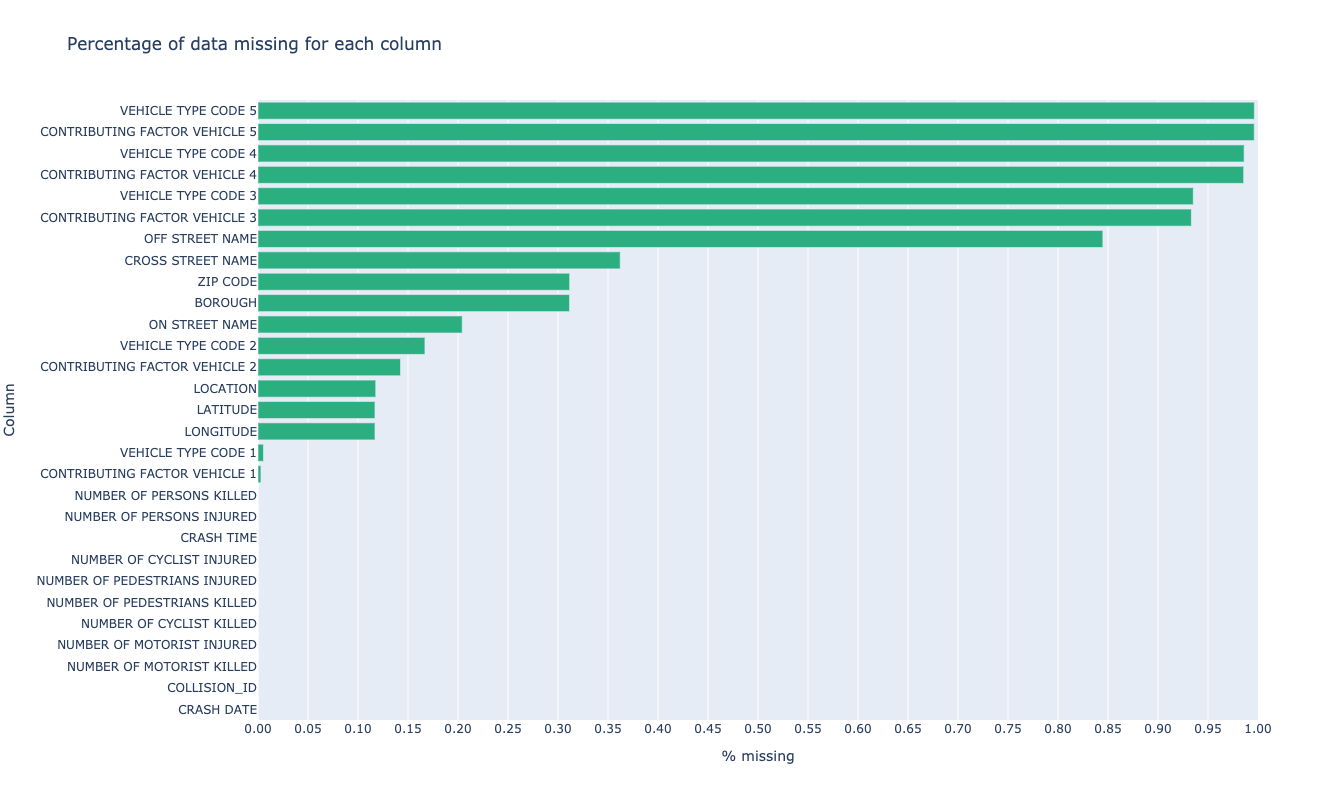

In [4]:
missing_pct_df = pd.DataFrame((df.isnull().sum(axis=0)/len(df)).sort_values(ascending=True)).reset_index(); missing_pct_df.columns = ['Column', 'Percentage missing']

import plotly.express as px
fig = px.bar(missing_pct_df, x="Percentage missing", y="Column", orientation='h', width = 1000, height=800, title='Percentage of data missing for each column')
fig.update_layout(
    xaxis_title="% missing",
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1.05,0.05),
        ticktext = ['{0:.2f}'.format(x) for x in np.arange(0, 1.05, 0.05)]
    ),
    hoverlabel_font_color='White')
fig.update_xaxes(range=[0, 1], row=1, col=1)

fig.update_traces(
    marker_color='rgb(43,174,128)'
)

fig.show()

## Preprocessing - Part 2: *Cleaning up `LOCATION`, `LATITUDE` and `LONGITUDE`*

Firstly, the **11.7% of the observations** where `LOCATION` was missing were dropped. Then outliers in the location were removed by selecting an appropriate interval for latitudes and longitudes for New York, which is plotted below.

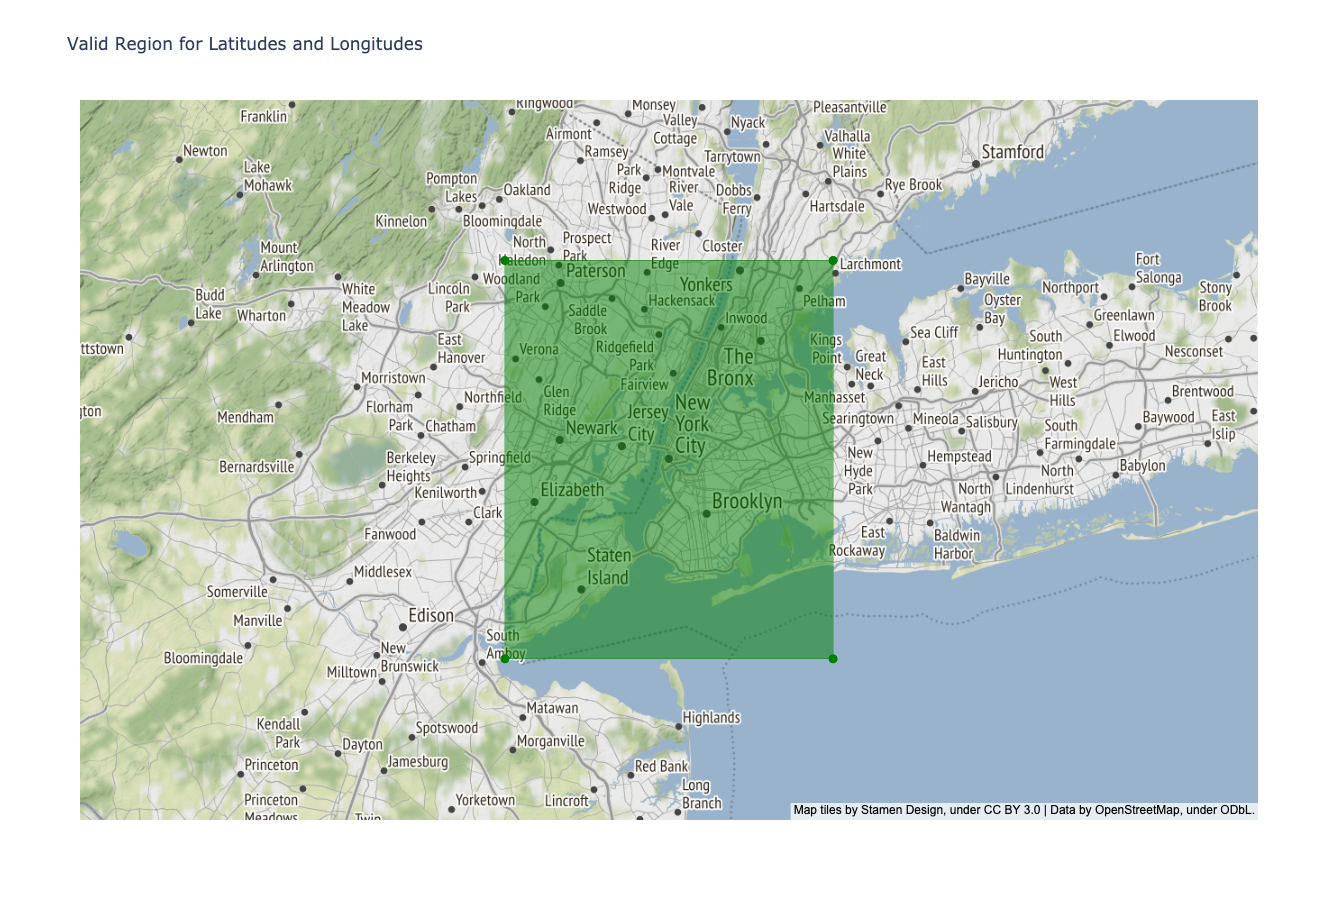

In [5]:
import plotly.graph_objects as go
lon_center = -74.006058
lat_center = 40.712772
lat_width = 0.23
lon_width  = 0.25

fig = go.Figure(go.Scattermapbox(
    fill = "toself",
    lon = [lon_center-lon_width, lon_center+lon_width, lon_center+lon_width, lon_center-lon_width], lat = [lat_center+lat_width, lat_center+lat_width, lat_center-lat_width, lat_center-lat_width],
    marker = { 'size': 10, 'color': "green" }))

fig.update_layout(
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -74.006058, 'lat': 40.712772},
        'zoom': 8.85},
    showlegend = False, width=1200, height=900, title='Valid Region for Latitudes and Longitudes')

fig.show()

#Drop rows where LOCATION is missing.
df = df.loc[~df['LOCATION'].isna()]

#Drop rows outside the green box below.
df = df.loc[(df['LONGITUDE'] >= lon_center - lon_width) & 
            (df['LONGITUDE'] <= lon_center + lon_width) & 
            (df['LATITUDE']  >= lat_center - lat_width) & 
            (df['LATITUDE'] <= lat_center + lat_width)]

In [12]:
print(f'Shape of dataset after removing invalid locations: {df.shape}')

np.any(pd.isna(df[['LOCATION','LATITUDE','LONGITUDE']]),axis=0)

Shape of dataset after removing invalid locations: (1394545, 29)


LOCATION     False
LATITUDE     False
LONGITUDE    False
dtype: bool

We now have 1394545 observations left, which meant we have discarded approximately 15% of the data thus far by discarding nans and locations outside of the green square above. On the other hand, we no longer have any nans in `LOCATION`, `LATITUDE` or `LONGITUDE`. **Great success!**

## Preprocessing - Part 3: *Cleaning up `BOROUGH` and `ZIP CODE`*

Now all rows have `LATITUDE` and `LONGITUDE` data, which means that there is no excuse for `BOROUGH` or `ZIP CODE` being nan! We will deal with this next:

In [15]:
(_, data_complete), (_, data_missing) = df.groupby(np.any(pd.isna(df[['ZIP CODE', 'BOROUGH']]), axis=1))

print(f'Number of rows with either ZIP or BOROUGH missing: {len(data_complete)}')
data_complete.head()

Number of rows with either ZIP or BOROUGH missing: 1059705


CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
199  12/28/2020      17:28      BRONX   10456.0  40.824066 -73.908714   
218  12/17/2020      14:43     QUEENS   11368.0  40.747650 -73.863010   
221  12/15/2020      11:00  MANHATTAN   10002.0  40.713920 -73.991714   
224  12/14/2020      17:11      BRONX   10459.0  40.820990 -73.895890   
236  12/08/2020      19:52   BROOKLYN   11229.0  40.599728 -73.937920   

                    LOCATION                    ON STREET NAME  \
199  (40.824066, -73.908714)  3 AVENUE                           
218    (40.74765, -73.86301)                               NaN   
221   (40.71392, -73.991714)                               NaN   
224    (40.82099, -73.89589)  KELLY STREET                       
236   (40.599728, -73.93792)                               NaN   

    CROSS STREET NAME                           OFF STREET NAME  \
199   EAST 163 STREET                                       NaN   
218               NaN  102-02    42 AVENUE                        
221               NaN  129       EAST BROADWAY                    
224   EAST 163 STREET                                       NaN   
236               NaN  2152      FORD STREET                      

     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
199                        0.0                       0.0   
218                        0.0                       0.0   
221                        0.0                       0.0   
224                        0.0                       0.0   
236                        0.0                       0.0   

     NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
199                              0                             0   
218                              0                             0   
221                              0                             0   
224                              0                             0   
236                              0                             0   

     NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
199                          0                         0   
218                          0                         0   
221                          0                         0   
224                          0                         0   
236                          0                         0   

     NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  \
199                           0                          0   
218                           0                          0   
221                           0                          0   
224                           0                          0   
236                           0                          0   

    CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
199                   Unspecified                   Unspecified   
218                   Unspecified                           NaN   
221                   Unspecified                           NaN   
224                   Unspecified                           NaN   
236                   Unspecified                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
199                           NaN                           NaN   
218                           NaN                           NaN   
221                           NaN                           NaN   
224                           NaN                           NaN   
236                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID     VEHICLE TYPE CODE 1  \
199                           NaN       4379833                   Sedan   
218                           NaN       4376945  Tractor Truck Gasoline   
221                           NaN       4376264                   Sedan   
224                           NaN       4376147                   Sedan   
236                           NaN       4374372                   Sedan   

    V

In [16]:
print(f'Number of rows with either ZIP or BOROUGH missing: {len(data_missing)}')
data_missing.head()

Number of rows with either ZIP or BOROUGH missing: 334840


CRASH DATE CRASH TIME BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
217  12/18/2020      21:55     NaN       NaN  40.695970 -73.913370   
232  12/11/2020      14:43     NaN       NaN  40.843246 -73.945050   
237  12/08/2020       2:00     NaN       NaN  40.865100 -73.921890   
238  12/07/2020      10:00     NaN       NaN  40.820827 -73.950836   
243  12/05/2020      13:45     NaN       NaN  40.651863 -73.865360   

                    LOCATION                    ON STREET NAME  \
217    (40.69597, -73.91337)  KNICKERBOCKER AVENUE               
232   (40.843246, -73.94505)  HENRY HUDSON PARKWAY               
237     (40.8651, -73.92189)  SHERMAN AVENUE                     
238  (40.820827, -73.950836)  WEST 138 STREET                    
243   (40.651863, -73.86536)  BELT PARKWAY                       

    CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  \
217               NaN             NaN                        0.0   
232               NaN             NaN                        0.0   
237               NaN             NaN                        0.0   
238               NaN             NaN                        0.0   
243               NaN             NaN                        1.0   

     NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
217                       0.0                              0   
232                       0.0                              0   
237                       0.0                              0   
238                       0.0                              0   
243                       0.0                              0   

     NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
217                             0                          0   
232                             0                          0   
237                             0                          0   
238                             0                          0   
243                             0                          0   

     NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
217                         0                           0   
232                         0                           0   
237                         0                           0   
238                         0                           0   
243                         0                           1   

     NUMBER OF MOTORIST KILLED CONTRIBUTING FACTOR VEHICLE 1  \
217                          0         Following Too Closely   
232                          0         Following Too Closely   
237                          0  Aggressive Driving/Road Rage   
238                          0                   Unspecified   
243                          0         Following Too Closely   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
217                   Unspecified                           NaN   
232                   Unspecified                           NaN   
237                   Unspecified                           NaN   
238                           NaN                           NaN   
243                   Unspecified                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
217                           NaN                           NaN       4377213   
232                           NaN                           NaN       4375744   
237                           NaN                           NaN       4374133   
238                           NaN                           NaN       4374340   
243                           NaN                           NaN       4373337   

    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
217               Sedan                                  NaN   
232               Sedan                                  NaN   
237               Sedan                                Sedan   
238               Sedan                                  NaN   
243               Sedan  Station Wagon/Sport U

Instead of discarding rows with `BOROUGH` or `ZIP CODE` missing, we want to impute it using **K-Nearest Neighbors**. We want to train our model on `data_complete` above, but we found that even in this data, there are some ambiguities with ZIP codes. 

In [8]:
counts = data_complete.groupby(['ZIP CODE', 'BOROUGH']).size().reset_index(); counts.columns = ['ZIP CODE', 'BOROUGH', 'COUNT']
zips, n = np.unique(counts['ZIP CODE'], return_counts=True)
counts.loc[counts['ZIP CODE'].apply(lambda x : x in zips[n > 1])]

ZIP CODE   BOROUGH  COUNT
140   11208.0  BROOKLYN  12337
141   11208.0    QUEENS    156
169   11237.0  BROOKLYN   6367
170   11237.0    QUEENS    280
201   11385.0  BROOKLYN     30
202   11385.0    QUEENS  13513
213   11421.0  BROOKLYN      6
214   11421.0    QUEENS   4208

Here, we can see that there is a total of **472 observations**, which we wish to correct such that ZIP codes belong to a borough. If we look up ZIP code [11208](https://www.unitedstateszipcodes.org/11208/), we can indeed see that the majority of the ZIP code lies within Brooklyn (which is also reflected in the large majority of them being borough Brooklyn in the table above). We fix this by assigning each ZIP code according to the majority. **Note: This gives us a mapping from ZIP code to Borough. We can therefore impute `ZIP CODE` using KNN, and then map from `ZIP CODE` to `BOROUGH` using our majority-vote system.**

In [9]:
#We make a mapping between zip code and the correct borough.
zip_to_borough = {}
for zip_, subset in counts.groupby('ZIP CODE'): zip_to_borough[zip_] = subset.sort_values('COUNT', ascending=False)['BOROUGH'].iloc[0]

#Let us look at a few examples of our remapping.
pd.DataFrame(zip_to_borough.items(), columns=['From', 'To']).sample(frac=1).head() #.sample(frac=1) just shuffles it so we can look at a few different ones.

From         To
194  11374.0     QUEENS
86   10282.0  MANHATTAN
1    10001.0  MANHATTAN
161  11230.0   BROOKLYN
42   10055.0  MANHATTAN

In [10]:
remapped_boroughs = data_complete['ZIP CODE'].replace(zip_to_borough)
n_remaps = (remapped_boroughs != data_complete['BOROUGH']).sum()
print(f'{n_remaps} boroughs were remapped.')
data_complete['BOROUGH'] = remapped_boroughs

472 boroughs were remapped.


### K-Nearest-Neighbor Imputation of the ZIP code

For the locations with missing **ZIP code** but not missing **location** (334840 observations in total), the ZIP code was imputed using a KNN classifier using $k=3$ nearest neighbors. The zip code could then be mapped to the borough using majority voting as was discussed previously. As seen below, the classification of borough was fairly succesful, which meant that a lot of data that otherwise had been discarded was used.

In [11]:
le = LabelEncoder()

Xtrain = data_complete[['LATITUDE', 'LONGITUDE']].values
ytrain = le.fit_transform(data_complete['ZIP CODE'].to_numpy())

clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(Xtrain,ytrain)

Ximpute = data_missing[['LATITUDE', 'LONGITUDE']].values
yimpute = le.inverse_transform(clf.predict(Ximpute))

Before imputing `BOROUGH` and `ZIP CODE` in `data_missing`:

In [12]:
data_missing.head()

CRASH DATE CRASH TIME BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
217  12/18/2020      21:55     NaN       NaN  40.695970 -73.913370   
232  12/11/2020      14:43     NaN       NaN  40.843246 -73.945050   
237  12/08/2020       2:00     NaN       NaN  40.865100 -73.921890   
238  12/07/2020      10:00     NaN       NaN  40.820827 -73.950836   
243  12/05/2020      13:45     NaN       NaN  40.651863 -73.865360   

                    LOCATION                    ON STREET NAME  \
217    (40.69597, -73.91337)  KNICKERBOCKER AVENUE               
232   (40.843246, -73.94505)  HENRY HUDSON PARKWAY               
237     (40.8651, -73.92189)  SHERMAN AVENUE                     
238  (40.820827, -73.950836)  WEST 138 STREET                    
243   (40.651863, -73.86536)  BELT PARKWAY                       

    CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  \
217               NaN             NaN                        0.0   
232               NaN             NaN                        0.0   
237               NaN             NaN                        0.0   
238               NaN             NaN                        0.0   
243               NaN             NaN                        1.0   

     NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
217                       0.0                              0   
232                       0.0                              0   
237                       0.0                              0   
238                       0.0                              0   
243                       0.0                              0   

     NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
217                             0                          0   
232                             0                          0   
237                             0                          0   
238                             0                          0   
243                             0                          0   

     NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
217                         0                           0   
232                         0                           0   
237                         0                           0   
238                         0                           0   
243                         0                           1   

     NUMBER OF MOTORIST KILLED CONTRIBUTING FACTOR VEHICLE 1  \
217                          0         Following Too Closely   
232                          0         Following Too Closely   
237                          0  Aggressive Driving/Road Rage   
238                          0                   Unspecified   
243                          0         Following Too Closely   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
217                   Unspecified                           NaN   
232                   Unspecified                           NaN   
237                   Unspecified                           NaN   
238                           NaN                           NaN   
243                   Unspecified                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
217                           NaN                           NaN       4377213   
232                           NaN                           NaN       4375744   
237                           NaN                           NaN       4374133   
238                           NaN                           NaN       4374340   
243                           NaN                           NaN       4373337   

    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
217               Sedan                                  NaN   
232               Sedan                                  NaN   
237               Sedan                                Sedan   
238               Sedan                                  NaN   
243               Sedan  Station Wagon/Sport U

After imputing `BOROUGH` and `ZIP CODE` in `data_missing`: 

In [13]:
data_missing['ZIP CODE'] = yimpute
data_missing['BOROUGH']  = data_missing['ZIP CODE'].replace(zip_to_borough)
data_missing.head()

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
217  12/18/2020      21:55   BROOKLYN   11221.0  40.695970 -73.913370   
232  12/11/2020      14:43  MANHATTAN   10032.0  40.843246 -73.945050   
237  12/08/2020       2:00  MANHATTAN   10034.0  40.865100 -73.921890   
238  12/07/2020      10:00  MANHATTAN   10031.0  40.820827 -73.950836   
243  12/05/2020      13:45   BROOKLYN   11234.0  40.651863 -73.865360   

                    LOCATION                    ON STREET NAME  \
217    (40.69597, -73.91337)  KNICKERBOCKER AVENUE               
232   (40.843246, -73.94505)  HENRY HUDSON PARKWAY               
237     (40.8651, -73.92189)  SHERMAN AVENUE                     
238  (40.820827, -73.950836)  WEST 138 STREET                    
243   (40.651863, -73.86536)  BELT PARKWAY                       

    CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  \
217               NaN             NaN                        0.0   
232               NaN             NaN                        0.0   
237               NaN             NaN                        0.0   
238               NaN             NaN                        0.0   
243               NaN             NaN                        1.0   

     NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
217                       0.0                              0   
232                       0.0                              0   
237                       0.0                              0   
238                       0.0                              0   
243                       0.0                              0   

     NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
217                             0                          0   
232                             0                          0   
237                             0                          0   
238                             0                          0   
243                             0                          0   

     NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
217                         0                           0   
232                         0                           0   
237                         0                           0   
238                         0                           0   
243                         0                           1   

     NUMBER OF MOTORIST KILLED CONTRIBUTING FACTOR VEHICLE 1  \
217                          0         Following Too Closely   
232                          0         Following Too Closely   
237                          0  Aggressive Driving/Road Rage   
238                          0                   Unspecified   
243                          0         Following Too Closely   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
217                   Unspecified                           NaN   
232                   Unspecified                           NaN   
237                   Unspecified                           NaN   
238                           NaN                           NaN   
243                   Unspecified                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
217                           NaN                           NaN       4377213   
232                           NaN                           NaN       4375744   
237                           NaN                           NaN       4374133   
238                           NaN                           NaN       4374340   
243                           NaN                           NaN       4373337   

    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
217               Sedan                                  NaN   
232               Sedan                                  NaN   
237               Sedan                                Sedan   
238               Sedan                                  NaN   
243               Sedan  Sta

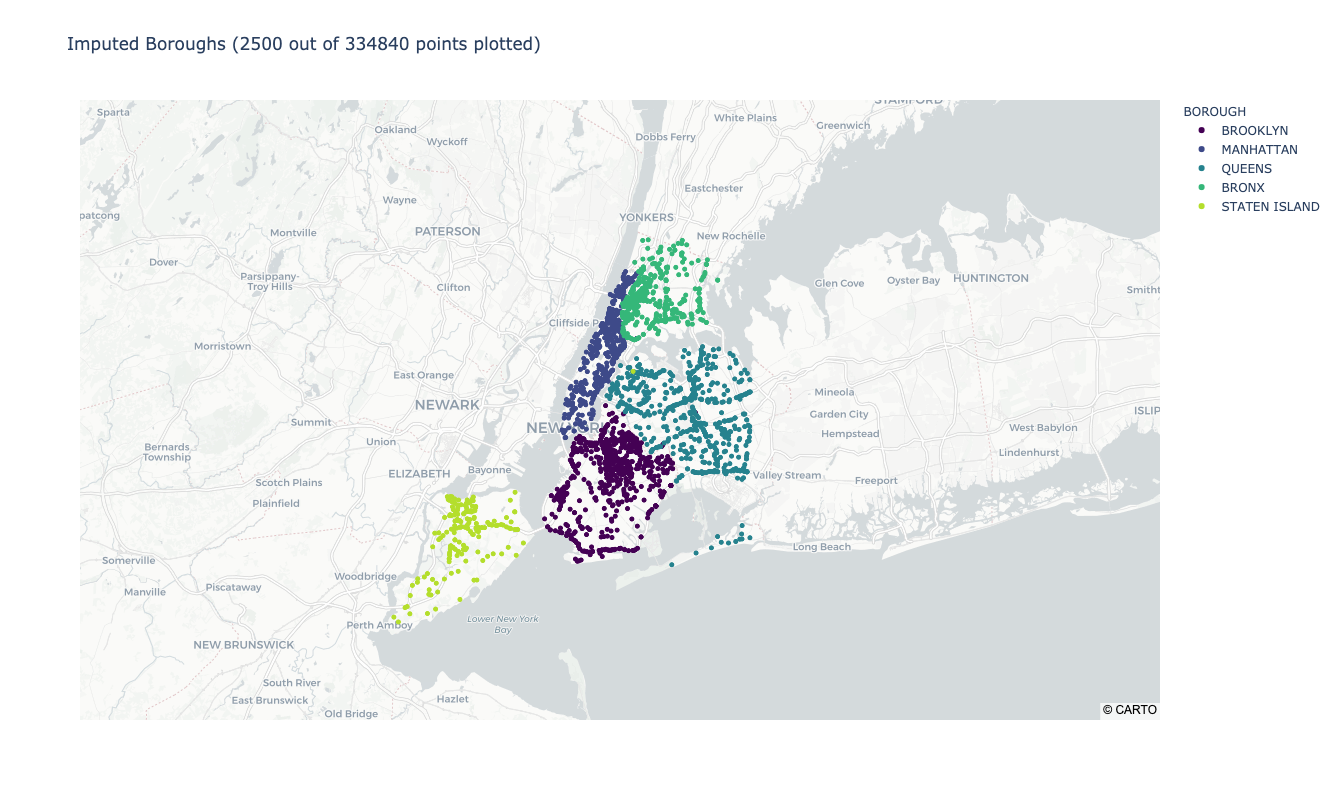

In [14]:
fig = px.scatter_mapbox(data_missing[:2500], lat='LATITUDE', lon='LONGITUDE', color='BOROUGH',
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="carto-positron",
                        width = 800, height = 800, title='Imputed Boroughs (2500 out of 334840 points plotted)',
                        color_discrete_sequence=['#440154', '#3e4a89','#26828e','#35b779','#b4de2c'])

fig.show()

Generally, it can be seen that the borough imputing is fairly succesful for many of the observations. Here, $k=3$ nearest neighbours, but a better accuracy in terms of ZIP code was preferred, then it would make sense to increase $k$. 

In [15]:
df = data_complete.append(data_missing)
df.head()

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
199  12/28/2020      17:28      BRONX   10456.0  40.824066 -73.908714   
218  12/17/2020      14:43     QUEENS   11368.0  40.747650 -73.863010   
221  12/15/2020      11:00  MANHATTAN   10002.0  40.713920 -73.991714   
224  12/14/2020      17:11      BRONX   10459.0  40.820990 -73.895890   
236  12/08/2020      19:52   BROOKLYN   11229.0  40.599728 -73.937920   

                    LOCATION                    ON STREET NAME  \
199  (40.824066, -73.908714)  3 AVENUE                           
218    (40.74765, -73.86301)                               NaN   
221   (40.71392, -73.991714)                               NaN   
224    (40.82099, -73.89589)  KELLY STREET                       
236   (40.599728, -73.93792)                               NaN   

    CROSS STREET NAME                           OFF STREET NAME  \
199   EAST 163 STREET                                       NaN   
218               NaN  102-02    42 AVENUE                        
221               NaN  129       EAST BROADWAY                    
224   EAST 163 STREET                                       NaN   
236               NaN  2152      FORD STREET                      

     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
199                        0.0                       0.0   
218                        0.0                       0.0   
221                        0.0                       0.0   
224                        0.0                       0.0   
236                        0.0                       0.0   

     NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
199                              0                             0   
218                              0                             0   
221                              0                             0   
224                              0                             0   
236                              0                             0   

     NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
199                          0                         0   
218                          0                         0   
221                          0                         0   
224                          0                         0   
236                          0                         0   

     NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  \
199                           0                          0   
218                           0                          0   
221                           0                          0   
224                           0                          0   
236                           0                          0   

    CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
199                   Unspecified                   Unspecified   
218                   Unspecified                           NaN   
221                   Unspecified                           NaN   
224                   Unspecified                           NaN   
236                   Unspecified                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
199                           NaN                           NaN   
218                           NaN                           NaN   
221                           NaN                           NaN   
224                           NaN                           NaN   
236                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID     VEHICLE TYPE CODE 1  \
199                           NaN       4379833                   Sedan   
218                           NaN       4376945  Tractor Truck Gasoline   
221                           NaN       4376264                   Sedan   
224                           NaN       4376147                   Sedan   
236                           NaN       4374372                   Sedan   

    V

## Preprocessing - Part 4: *Encoding Contributing Factors* 

First, we want to fill `NaN`s in `CONTRIBUTING FACTOR VEHICLE 1` with "Unspecified", since for every collision there is at least one vehicle. 

In [16]:
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unspecified')

Now, we wish to encode the contributing factors for all vehicles in a single column. As an example, the used encoding is demonstrated on the small snippet below:

In [17]:
df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15]

CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
280                   Unspecified                           NaN   
291                   Unspecified                           NaN   
317       View Obstructed/Limited                           NaN   
323                   Unspecified                   Unspecified   
339              Backing Unsafely                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
280                           NaN                           NaN   
291                           NaN                           NaN   
317                           NaN                           NaN   
323                           NaN                           NaN   
339                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  
280                           NaN  
291                           NaN  
317                           NaN  
323                           NaN  
339                           NaN

The used encoding is shown below:

In [18]:
encoded = pd.DataFrame({'CF_Unspecified' : df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].apply(lambda x : 'Unspecified' in list(x), axis=1).astype(int),
                        'CF_Driver Backing Unsafely' : df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].apply(lambda x : 'Backing Unsafely' in list(x), axis=1).astype(int),
                        'CF_View Obstructed/Limited' : df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].apply(lambda x : 'View Obstructed/Limited' in list(x), axis=1).astype(int)})

df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].join(encoded)

CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
280                   Unspecified                           NaN   
291                   Unspecified                           NaN   
317       View Obstructed/Limited                           NaN   
323                   Unspecified                   Unspecified   
339              Backing Unsafely                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
280                           NaN                           NaN   
291                           NaN                           NaN   
317                           NaN                           NaN   
323                           NaN                           NaN   
339                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  CF_Unspecified  CF_Driver Backing Unsafely  \
280                           NaN               1                           0   
291                           NaN               1                           0   
317                           NaN               0                           0   
323                           NaN               1                           0   
339                           NaN               0                           1   

     CF_View Obstructed/Limited  
280                           0  
291                           0  
317                           1  
323                           0  
339                           0

where e.g. `CF_Backing Unsafely = 1` indicates that one of the contributing factors was labeled as "Backing Unsafely". This means that we will add quite a lot of new columns since we have quite a lot of contributing factors.

**Please beware that the following code chunk takes approxmately 15 minutes to run!**

In [19]:
t1 = time.time()

unique_factors = np.unique(df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values.reshape(-1,).astype(str))
print(f'Number of unique factors: {len(unique_factors)}')

for i, factor in enumerate(unique_factors):
    df[f'CF_{factor}'] = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].astype(str).apply(lambda x : factor in list(x), axis=1).astype(int)
    print(f'Encoded factor {str(i+1).zfill(2)}/{len(unique_factors)}.', end='\r')
    
print('')
t2 = time.time()
print(f'Contributing factors encoded. Total time elapsed: {t2-t1} seconds.')

Number of unique factors: 62
Encoded factor 62/62.
Contributing factors encoded. Total time elapsed: 1338.8837749958038 seconds.


In [29]:
df['CF_Drugs (illegal)'] = (df['CF_Drugs (illegal)']|df['CF_Drugs (Illegal)']); 
df['CF_Cell Phone (hand-held)'] = (df['CF_Cell Phone (hand-held)']|df['CF_Cell Phone (hand-Held)']); 
df['CF_Illness'] = (df['CF_Illness']|df['CF_Illnes']); 


df.drop('CF_Drugs (Illegal)', axis=1, inplace=True)
df.drop('CF_Cell Phone (hand-Held)', axis=1, inplace=True)
df.drop('CF_Illnes', axis=1, inplace=True)

Along with the encoding of the contributing factors, we found that some of the contributing factors were clearly the same, e.g `CF_Drugs (illegal)` and `CF_Drugs (Illegal)`. These were corrected in the code above.

**Important note: `CF_nan` is also a column. Unless 5 vehicles were involved, `CF_nan = 1`, meaning that it is almost always 1. Also, `CF_Unspecified` is also a contributing factor, meaning that if a policeman noted "Unspecified" for one of the vehicles then `CF_Unspecified=1`, meaning that `CF_Unspecified=1` will also be pretty common. Therefore these two columns will often be overlooked in our analysis on the webpage since they do not tell us something meaningful about the contributing factor.**

## Preprocessing - Part 5: *Last Cleaning and Final Dataset*

During the last part of the data preperation, some special rows were removed due to inconsistencies: 
- 11 rows were discarded due to `NUMBER OF PERSONS KILLED` not matching `NUMBER OF PEDESTRIANS KILLED`, `NUMBER OF CYCLISTS KILLED` and `NUMBER OF MOTORIST KILLED`. 
- Likewise, 534 rows were discarded due to `NUMBER OF PERSONS INJURED` not matching `NUMBER OF PEDESTRIANS INJURED`, `NUMBER OF CYCLISTS INJURED` and `NUMBER OF MOTORIST INJURED`.

A new column, `TIME` is also added that combines the information from `CRASH DATE` and `CRASH TIME`. 

In [20]:
#Fix issues with mismatch
df = df.loc[df['NUMBER OF PERSONS KILLED'].fillna(0) == df[[x for x in df.columns if x.endswith('KILLED') and x.find('PERSONS')==-1]].sum(axis=1)]
df = df.loc[df['NUMBER OF PERSONS INJURED'].fillna(0) == df[[x for x in df.columns if x.endswith('INJURED') and x.find('PERSONS')==-1]].sum(axis=1)]
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].fillna(0)
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].fillna(0)

#Construct time from CRASH DATE and CRASH TIME.
df['TIME'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']
df['TIME'] = pd.to_datetime(df['TIME'], format="%m/%d/%Y %H:%M")

Having done the last cleaning, let us have a look at the final dataset.

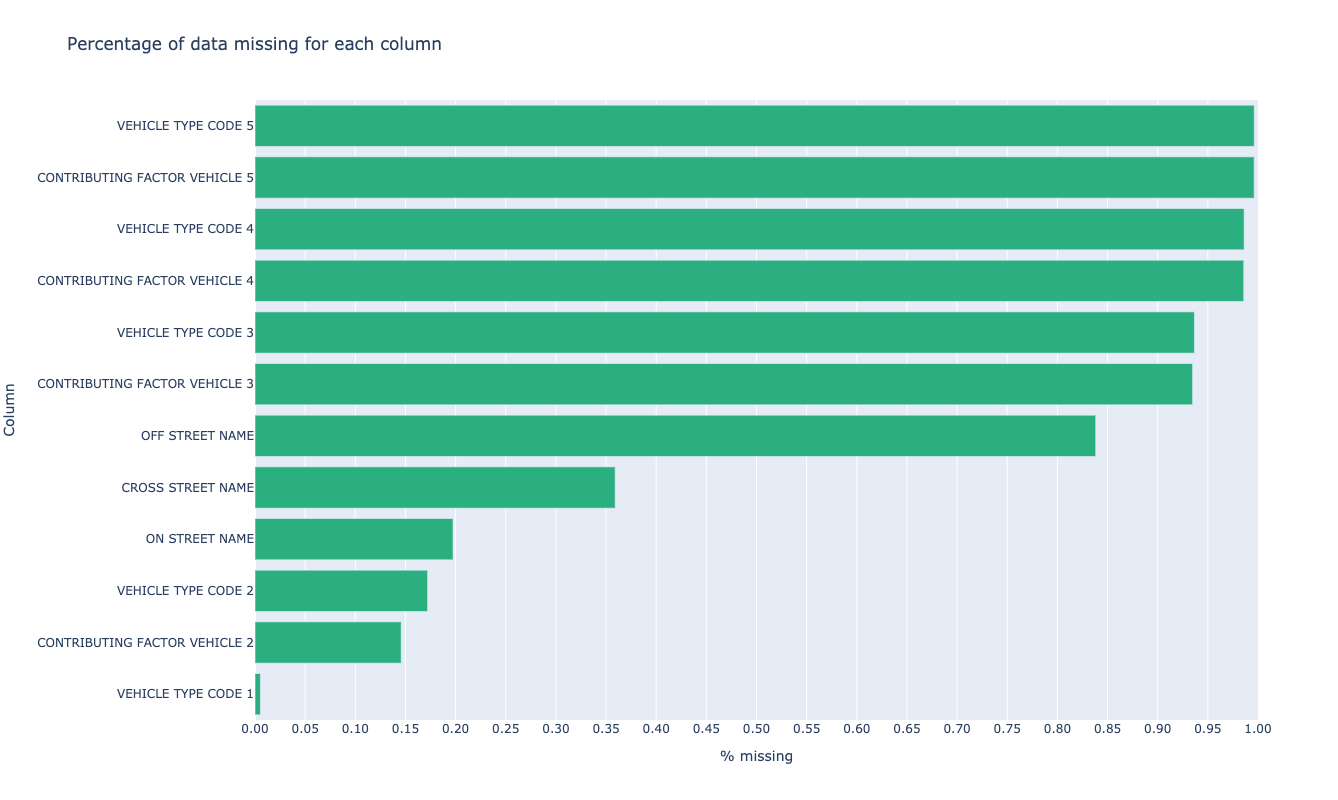

In [21]:
missing_pct_df = pd.DataFrame((df.isnull().sum(axis=0)/len(df)).sort_values(ascending=True)).reset_index(); missing_pct_df.columns = ['Column', 'Percentage missing']
missing_pct_df = missing_pct_df.loc[missing_pct_df['Percentage missing'] > 0]
import plotly.express as px
fig = px.bar(missing_pct_df, x="Percentage missing", y="Column", orientation='h', width = 1000, height=800, title='Percentage of data missing for each column')
fig.update_layout(
    xaxis_title="% missing",
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1.05,0.05),
        ticktext = ['{0:.2f}'.format(x) for x in np.arange(0, 1.05, 0.05)]
    ),
    hoverlabel_font_color='White')
fig.update_xaxes(range=[0, 1], row=1, col=1)

fig.update_traces(
    marker_color='rgb(43,174,128)'
)

fig.show()

We can see that in our dataset, there is still some missing values in `ON STREET NAME`, `CROSS STREET NAME` and `OFF STREET NAME` that could be imputed, but seeing as it is not used in this project, it was not looked into further. Also, due to the nature of the observations, there are still a lot of missing values in some of the `CONTRIBUTING FACTOR VEHICLE` columns. But if there are only 2 cars in a given collision, then it would be true that `CONRIBUTING FACTOR VEHICLE 3` is missing.

In [22]:
print(f'Shape of the final dataset {df.shape}')
df.head()

Shape of the final dataset (1394023, 92)


CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
199  12/28/2020      17:28      BRONX   10456.0  40.824066 -73.908714   
218  12/17/2020      14:43     QUEENS   11368.0  40.747650 -73.863010   
221  12/15/2020      11:00  MANHATTAN   10002.0  40.713920 -73.991714   
224  12/14/2020      17:11      BRONX   10459.0  40.820990 -73.895890   
236  12/08/2020      19:52   BROOKLYN   11229.0  40.599728 -73.937920   

                    LOCATION                    ON STREET NAME  \
199  (40.824066, -73.908714)  3 AVENUE                           
218    (40.74765, -73.86301)                               NaN   
221   (40.71392, -73.991714)                               NaN   
224    (40.82099, -73.89589)  KELLY STREET                       
236   (40.599728, -73.93792)                               NaN   

    CROSS STREET NAME                           OFF STREET NAME  \
199   EAST 163 STREET                                       NaN   
218               NaN  102-02    42 AVENUE                        
221               NaN  129       EAST BROADWAY                    
224   EAST 163 STREET                                       NaN   
236               NaN  2152      FORD STREET                      

     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
199                        0.0                       0.0   
218                        0.0                       0.0   
221                        0.0                       0.0   
224                        0.0                       0.0   
236                        0.0                       0.0   

     NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
199                              0                             0   
218                              0                             0   
221                              0                             0   
224                              0                             0   
236                              0                             0   

     NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
199                          0                         0   
218                          0                         0   
221                          0                         0   
224                          0                         0   
236                          0                         0   

     NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  \
199                           0                          0   
218                           0                          0   
221                           0                          0   
224                           0                          0   
236                           0                          0   

    CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
199                   Unspecified                   Unspecified   
218                   Unspecified                           NaN   
221                   Unspecified                           NaN   
224                   Unspecified                           NaN   
236                   Unspecified                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
199                           NaN                           NaN   
218                           NaN                           NaN   
221                           NaN                           NaN   
224                           NaN                           NaN   
236                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID     VEHICLE TYPE CODE 1  \
199                           NaN       4379833                   Sedan   
218                           NaN       4376945  Tractor Truck Gasoline   
221                           NaN       4376264                   Sedan   
224                           NaN       4376147                   Sedan   
236                           NaN       4374372                   Sedan   

    V

## Preprocessing - TL;DR

Quite a lot of preprocessing is going on, and therefore here is a brief recap of what was done to the data:

- We discarded `LATITUDE` and `LONGITUDES` that were either nans or outside the valid green box shown above.
- A mapping was made from `ZIP CODE` to `BOROUGH` based on the data. Missing `ZIP CODES` were imputed using KNN with $k=3$, and then mapped to a `BOROUGH`. 
- All contributing variables were meaningfully encoded. For instance, `CF_Fell Asleep = 1` means that "Fell Asleep" was a contributing factor in one of the involved vehicles for that given collision.
- Rows where the number of injured/killed was inconsistent were discarded. 

The original dataset was of size (1644188, 29), and our final dataset is of size (1394023, 91), where every observation has `LOCATION`, `ZIP CODE`, `BOROUGH` and has one or more contributing factors.

## Distribution Across Borough

Let us have a look at the distribution across borough.



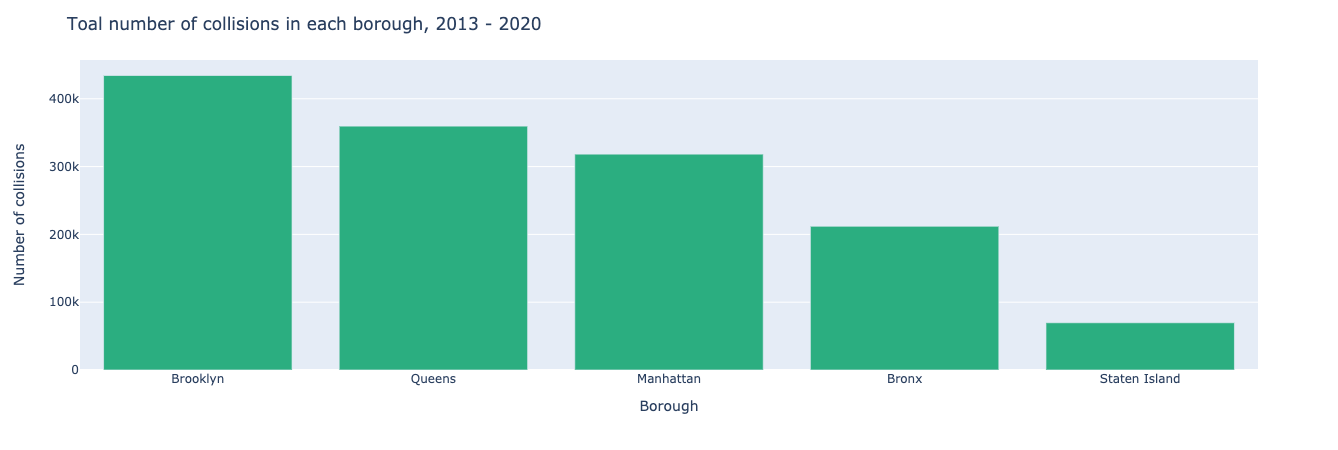

In [23]:
plot_borough = pd.DataFrame(df.groupby(df['BOROUGH']).size().reset_index().values, columns=['Borough','Count'])
plot_borough['Borough'] = plot_borough['Borough'].str.title()
plot_borough['citizen_N'] = pd.Series([1435000, 2590000, 1632000, 2287000 ,474893])
plot_borough['Area km2'] = pd.Series([110, 180,  59, 280 ,152])

fig = px.bar(plot_borough, x = 'Borough', y = 'Count', custom_data = plot_borough[['Borough', 'Count', 'citizen_N','Area km2']])

fig.update_layout(xaxis={'categoryorder':'total descending'},
    title="Toal number of collisions in each borough, 2013 - 2020",
    xaxis_title="Borough",
    yaxis_title="Number of collisions",
    hoverlabel_font_color='White')

fig.update_traces(
    hovertemplate="<br>".join([
        "Borough: %{x}",
        "Total number of collisions: %{y:,}",
        "",
        "Population (2019): %{customdata[2]:,}",
        "Area in km2: %{customdata[3]:,}",
        "Source: <b>%{x}, Wikipedia<b>"]

    ),
    selector=dict(type="bar"),
    marker_color='rgb(43,174,128)'
)

fig.show()
fig.write_html("plotly_html/collisions_borough.html")

We can see that the borough with the largest number of motor vehicle collisions the last seven years is Brooklyn with more than 400.000 collisions. Second is Queens. Two things to notice are the number of citizens and size of the area. While Brooklyn and Queens have the highest number of collisions, they also have the highest population and largest area respectively. That being said, the plot above still gives a good understanding of the number of collisions across boroughs.

## Contributing Factors

Let us have a look at some of the contributing factors.

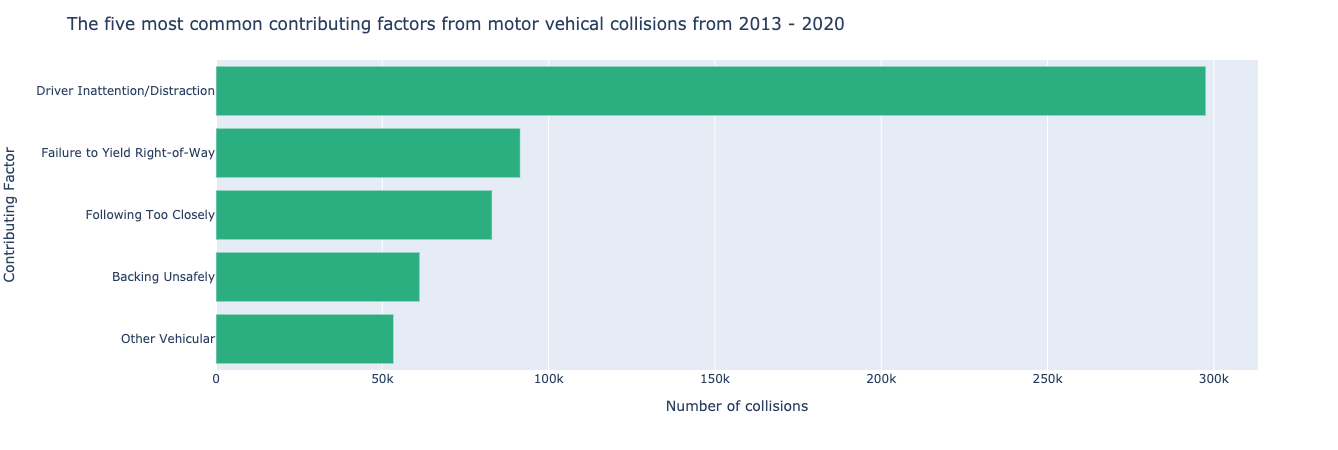

In [24]:
plot_contributing = pd.DataFrame(df[[x for x in df.columns if x.startswith('CF_')]].sum(axis=0).reset_index().values, columns=['Contributing Factor', 'Count']).sort_values(by='Count', ascending=False)
plot_contributing['Contributing Factor'] = plot_contributing['Contributing Factor'].str.replace('CF_','')
fig = px.bar(plot_contributing.iloc[2:7], y = 'Contributing Factor', x = 'Count', orientation = "h")
fig.update_layout(yaxis={'categoryorder':'total ascending'},
    title="The five most common contributing factors from motor vehical collisions from 2013 - 2020",
    xaxis_title="Number of collisions",
    hoverlabel_font_color='White')
fig.update_traces(
    hovertemplate="<br>".join([
        "Contributing Factor: %{y}",
        "Total number of collisions: %{x:,}",]
    ),
    selector=dict(type="bar"),
    marker_color='rgb(43,174,128)'
)

fig.show()

In the plot, we can see that the largest contributing factor is Driver Inattention/Distraction, which is a seperate subtopic that we decided to study more closely on the website. That being said, in the plot above, `CF_nan` and `CF_Unspecified` were also left out, since these are very often 1 as mentioned earlier.

In [25]:
pd.DataFrame({'Contributing Factor' : plot_contributing['Contributing Factor'], '% of observations' : plot_contributing['Count']/len(df)}).head()

Contributing Factor % of observations
61                             nan          0.996205
56                     Unspecified          0.809161
11  Driver Inattention/Distraction          0.213489
18   Failure to Yield Right-of-Way          0.065624
21           Following Too Closely          0.059543

We can see that 99% of collisions has at least one nan. **This is a good thing! Remember that if a collision only has 2 cars, then `CONTRIBUTING FACTOR VEHICLE 3` ... are all nan.**. 80% of collisions has 'Unspecified' for one of the involved vehicles. This could suggest that the NYPD still has some trouble getting used to 'MV-104AN' and the Finest Online Records Management System (FORMS), which was introduced in 2016. As previously mentioned though, these two columns are left out when looking at contributing factors as they do not give any meaningful information about the collision.

## Temporal Distributions

Let us have a look at the temporal distributions of the data.

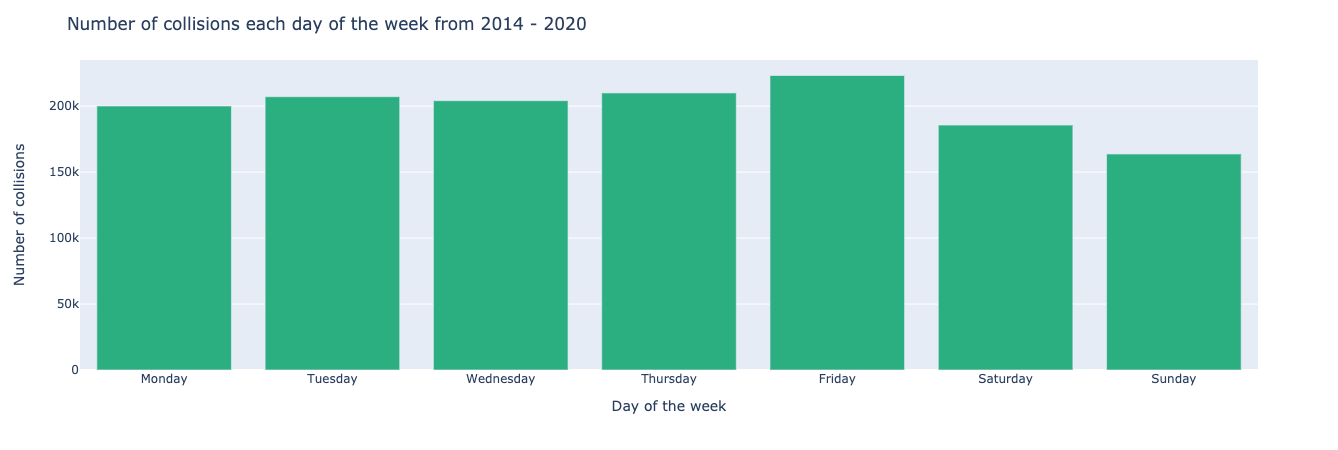

In [26]:
plot_weekday= pd.DataFrame(df.groupby(df['TIME'].dt.weekday).size().reset_index().values, columns=['Day of the Week','Count'])
plot_weekday['change'] = plot_weekday['Count'].pct_change().fillna(0)*100

fig = px.bar(plot_weekday, x =["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"], y = 'Count',
            custom_data = plot_weekday[['Day of the Week', 'Count', 'change']])
fig.update_layout(
    title="Number of collisions each day of the week from 2014 - 2020",
    xaxis_title="Day of the week", 
    yaxis_title="Number of collisions",
    hoverlabel_font_color='White')
fig.update_traces(
    hovertemplate="<br>".join([
        "Day of the week: %{x}",
        "Total number of collisions: %{y:,}",
        "Day-to-day change: %{customdata[2]:.2f} %"]
    ),
    selector=dict(type="bar"),
    marker_color='rgb(43,174,128)'
)

fig.update_layout()
fig.show()
#fig.write_html("plotly_html/collisions_day.html")

The number collisions out of the seven weekday are highest on Fridays and lowest on Sundays. We can see that the change from day to day variation is not great, with the higest difference being from Friday to Saturday with a decrease of nearly 20%. 

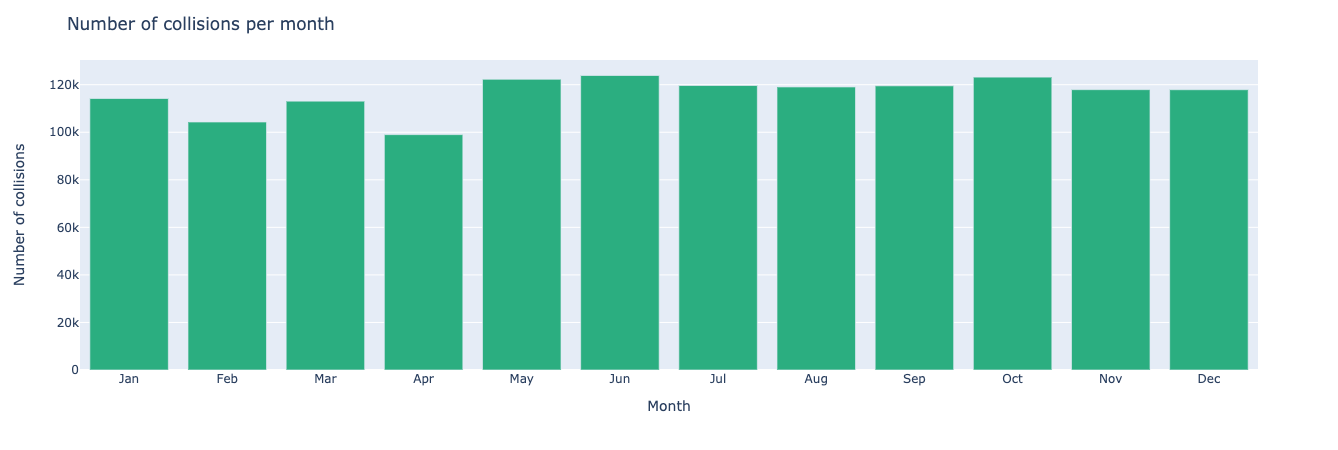

In [27]:
plot_month = pd.DataFrame(df.groupby(df['TIME'].dt.month).size().reset_index().values, columns=['Month','Count'])
fig = px.bar(plot_month, x =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], y = 'Count')
fig.update_layout(
    title="Number of collisions per month" ,
    xaxis_title="Month",
    yaxis_title="Number of collisions",
    hoverlabel_font_color='White')
fig.update_traces(
    hovertemplate="<br>".join([
        "Month: %{x}",
        "Total number of collisions: %{y:,}",
    ]),
    selector=dict(type="bar"),
    marker_color='rgb(43,174,128)'
)

fig.show()

Here we see the monthly variation of collisions, and the first thing to keep in mind is, that the plot is not normalized with the number of days in the month. Thus the lower number of collisions in February can be explain by the fewer days of the month. However we do see much fewer collisions happening in April month, and as mentioned on the website, this can perhaps be explained by the 'Distracted Driving Awareness Month' every April by the National Safety Council (NSC)

__[NSC website](https://www.nsc.org/road-safety/get-involved/distracted-driving-awareness-month)__

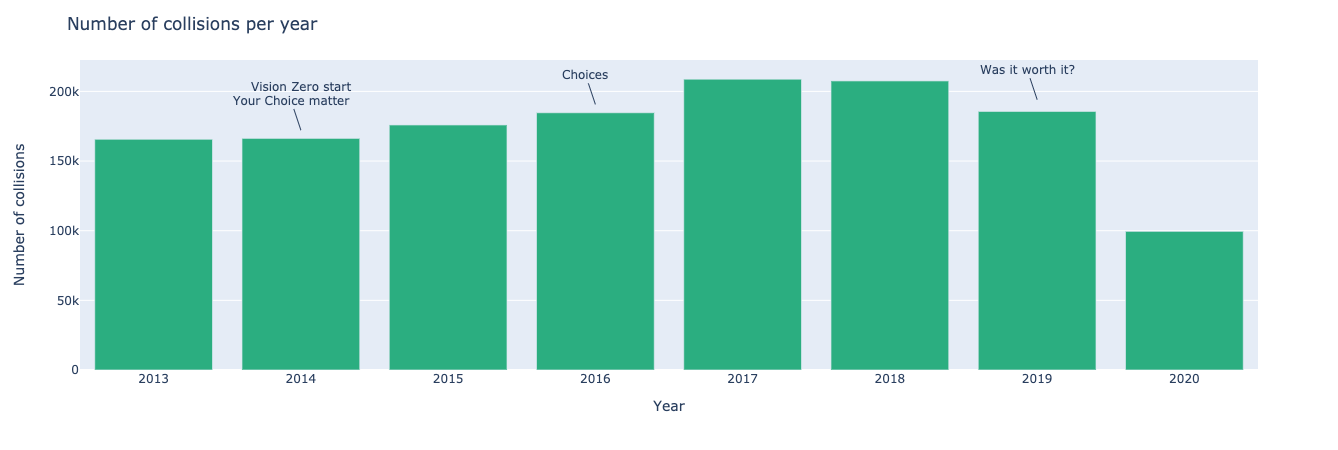

In [28]:
plot_year = pd.DataFrame(df.groupby(df['TIME'].dt.year).size().reset_index().values, columns=['Year','Count'])
# Yearly change 
plot_year['change'] = plot_year['Count'].pct_change().fillna(0)*100

fig = px.bar(plot_year, x ='Year', y = 'Count', custom_data = plot_year[['Year', 'Count', 'change']])

fig.update_layout(
    title="Number of collisions per year" ,
    xaxis_title="Year",
    yaxis_title="Number of collisions",
    hoverlabel_font_color='White')

fig.update_traces(
    hovertemplate="<br>".join([
        "Year: %{x}",
        "Total number of collisions: %{y:,}",
        "Year-to-year change: %{customdata[2]:.2f} %"
    ]),
    selector=dict(type="bar"),
    marker_color='rgb(43,174,128)'
)
fig.add_annotation(x=2014, y=196000,
            text="Vision Zero start" ,
            showarrow=False,
            yshift=10)
fig.add_annotation(x=2019, y=187000,
            text="Was it worth it?" ,
            showarrow=True,
            yshift=10)
fig.add_annotation(x=2014, y=165000,
            text="Your Choice matter" ,
            showarrow=True,
            yshift=10)

fig.add_annotation(x=2016, y=183500,
            text="Choices" ,
            showarrow=True,
            yshift=10)

fig.show()

#fig.write_html("plotly_html/collisions_year.html")

We have in the plot above, beside showing the total number of collisions per year, also marked some of Vision Zero's campagin troughout the last seven years. Looking at the plot it does not show that the campaigns have had an effect, if only looking at the total number of collisions per year. One have to be aware that eventhough one migth think that the campaign 'Was it worth it', have had an extremly large effect reducing the number of collisions with 46.46 % from 2019 to 2020, one have to keep in mind that NYC, just like the rest of the world, suffered greatly from the world pandamic, Covid-19. 

__[Vision Zero: Previous Awareness Campaigns](https://www1.nyc.gov/html/dot/html/about/campaigns.shtml)__ 

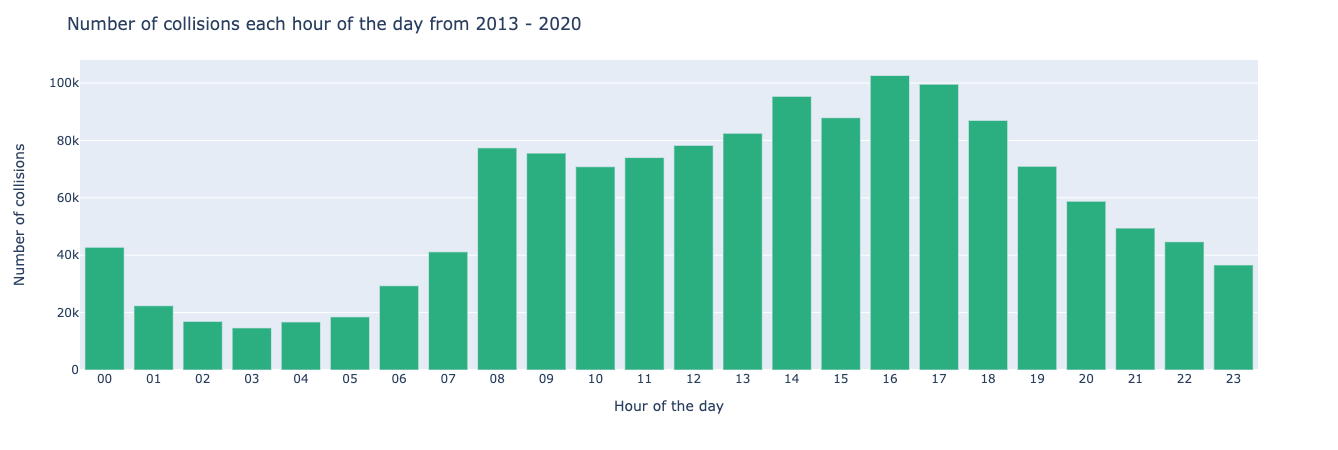

In [30]:
plot_hour = pd.DataFrame(df.groupby(df['TIME'].dt.hour).size().reset_index().values, columns=['Hour','Count'])
plot_hour['Hour'] = plot_hour['Hour'].astype(str).str.zfill(2)
plot_hour['change'] = plot_hour['Count'].pct_change().fillna(0)*100

fig = px.bar(plot_hour, x ='Hour', y = 'Count', custom_data = plot_hour[['Hour', 'Count', 'change']])

fig.update_layout(
    title="Number of collisions each hour of the day from 2013 - 2020" ,
    xaxis=dict(
        title='Hour of the day',
        tickmode='linear'),
    yaxis_title="Number of collisions",
    hoverlabel_font_color='White')

fig.update_traces(
    hovertemplate="<br>".join([
        "Hour of the day: %{x}",
        "Total number of collisions: %{y:,}",
        "Hour-to-Hour change: %{customdata[2]:.2f} %"
    ]),
    selector=dict(type="bar"),
    marker_color='rgb(43,174,128)'
)

fig.show()
#fig.write_html("plotly_html/collisions_hour.html")

In the plot above we can see that most of the collisions happen around 4 o'clock in the afternoon. This is a classic rush hour bottleneck problem, where everyone is off from school or work, and want to get home fast to start their enjoyable time off. The means that there will of course be more cars on the road it this point than at 02 o'clock in the night for instance. We will talk about this 'Curse of Rush Hour' below, and how we have taking it into considerations. 

# Data Analysis

## Death or Injury? 

For this project, we defined serious collisions as collisions where people are either injured or killed. By using this definition, the goal of Vision Zero is to eliminate all serious traffic collisions in New York City by 2024, and the analysis presented here could therefore help achieve this goal. 

In [17]:
table = df.groupby([df['NUMBER OF PERSONS KILLED'] > 0, df['NUMBER OF PERSONS INJURED'] > 0]).size().unstack(fill_value=0)
table

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning:

Columns (7,8,9,22,28) have mixed types.Specify dtype option on import or set low_memory=False.



NUMBER OF PERSONS INJURED    False   True 
NUMBER OF PERSONS KILLED                  
False                      1157463  290857
True                          1276     417

As we can see from the tables above, very few collisions are deadly and therefore we defined serious as either injuring or deadly seeing as we also wanted some data to work with.

## The Curse of Rush Hour

One of the key takeaways from this project is what we will refer to as **The Curse of Rush Hour**.

In all its simplicity, **The Curse of Rush Hour** is that we need to correct for the underlying temporal distribution of vehicle collisions. Most vehicle collisions occur during rush hour (around **08:00** and again **16:00-18:00**). This means that if we pose questions in terms of sheer collision counts, then the answer is most likely going to be during rush hour.

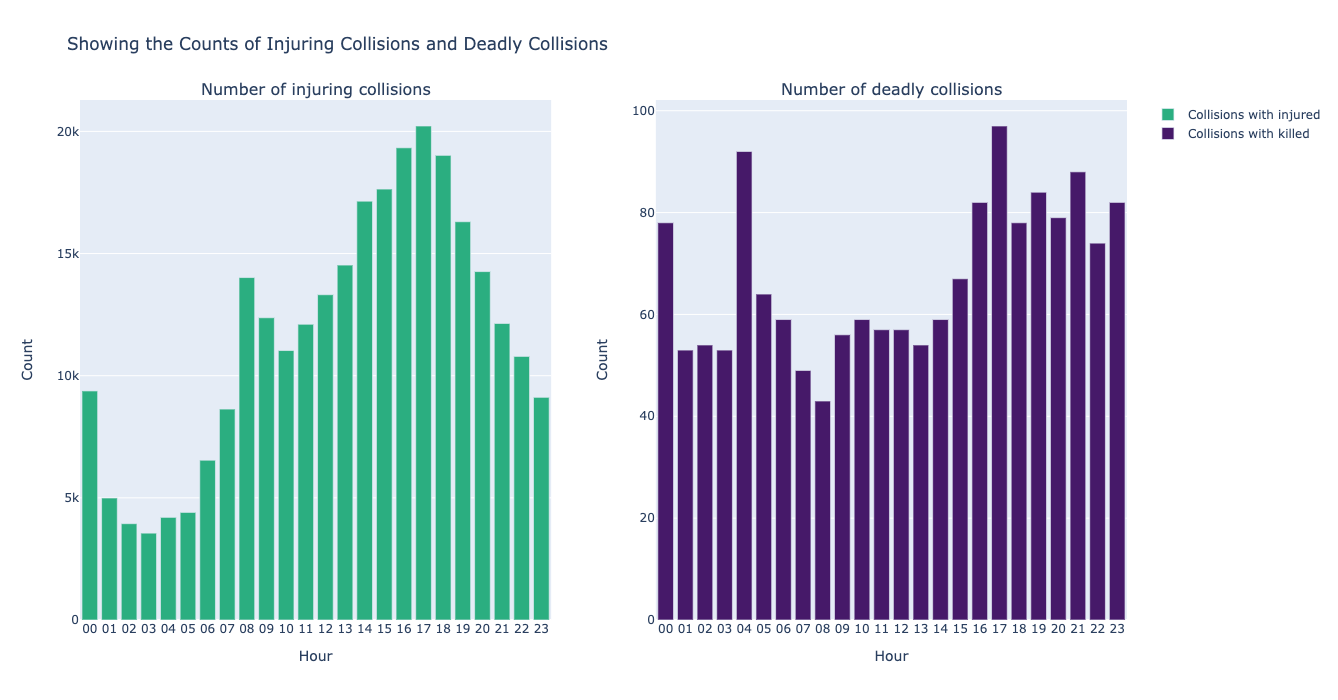

In [35]:
plot_injury = pd.DataFrame(df.loc[df['NUMBER OF PERSONS INJURED'] > 0].groupby(df['TIME'].dt.hour).size().reset_index().values, columns = ['Hour', 'Count'])
plot_injury['Hour'] = plot_injury['Hour'].astype(str).str.zfill(2)

plot_deadly = pd.DataFrame(df.loc[df['NUMBER OF PERSONS KILLED'] > 0].groupby(df['TIME'].dt.hour).size().reset_index().values, columns = ['Hour', 'Count'])
plot_deadly['Hour'] = plot_deadly['Hour'].astype(str).str.zfill(2)

count_plots = make_subplots(rows=1, cols=2, specs=[[{'type': 'xy'},{"type": "xy"}]],
                   subplot_titles=('Number of injuring collisions', 'Number of deadly collisions'))

count_plots.add_trace(
    go.Bar(x = plot_injury['Hour'], y = plot_injury['Count'], name='Collisions with injured',
          marker_color='#2bae80'),
    row=1, col=1, 
)


count_plots.add_trace(
    go.Bar(x = plot_deadly['Hour'], y=plot_deadly['Count'], name = 'Collisions with killed',
          marker_color='#461969'),
    row=1, col=2
)

count_plots.update_xaxes(title_text="Hour", row=1, col=1); count_plots.update_yaxes(title_text="Count", row=1, col=1)
count_plots.update_xaxes(title_text="Hour", row=1, col=2); count_plots.update_yaxes(title_text="Count", row=1, col=2)

count_plots.update_layout(title_text="Showing the Counts of Injuring Collisions and Deadly Collisions", height=700)

In the left plot above, we can see that in terms of injuring collisions, then there is a spike around **08:00** and a spike around **17:00**, but that injuring collisions mostly happen in the afternoon rush hour.

In the right plot above, we can see that in terms of deadly collisions, there is a *clear* spike around **04:00**, but that most deadly collisions happen at around **16:00**. 

Now, let us try making the same two plots, but instead of counting the number of collisions, we use the definition of the conditional probability:

$$ P(A | B) = \frac{P(A \cap B)}{P(B)} $$

where $P(A \cap B)$ is the probability that both events $A$ and $B$ occur. In our case, this means that we can take the plot above and divide with the baseline counts for hourly collisions.

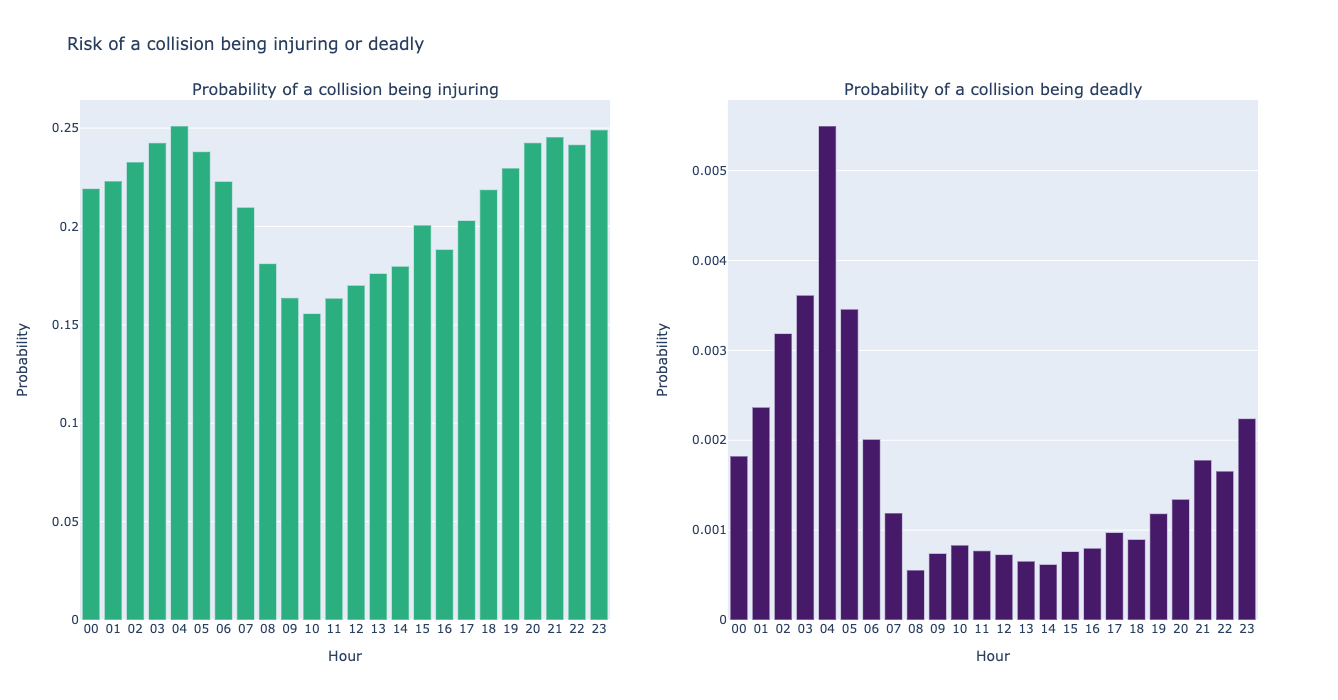

In [41]:
plot_injury = pd.DataFrame(df.loc[df['NUMBER OF PERSONS INJURED'] > 0].groupby(df['TIME'].dt.hour).size().reset_index().values, columns = ['Hour', 'Count'])
plot_injury['Hour'] = plot_injury['Hour'].astype(str).str.zfill(2)

plot_deadly = pd.DataFrame(df.loc[df['NUMBER OF PERSONS KILLED'] > 0].groupby(df['TIME'].dt.hour).size().reset_index().values, columns = ['Hour', 'Count'])
plot_deadly['Hour'] = plot_deadly['Hour'].astype(str).str.zfill(2)


baseline    = pd.DataFrame(df.groupby(df['TIME'].dt.hour).size().reset_index().values, columns=['Hour', 'Count'])

count_plots = make_subplots(rows=1, cols=2, specs=[[{'type': 'xy'},{"type": "xy"}]],
                   subplot_titles=('Probability of a collision being injuring', 'Probability of a collision being deadly'))

count_plots.add_trace(
    go.Bar(x = plot_injury['Hour'], y = plot_injury['Count']/baseline['Count'], name='Collisions with injured',
          marker_color='#2bae80'),
    row=1, col=1, 
)

count_plots.add_trace(
    go.Bar(x = plot_deadly['Hour'], y=plot_deadly['Count']/baseline['Count'], name = 'Collisions with killed',
          marker_color='#461969'),
    row=1, col=2
)

count_plots.update_xaxes(title_text="Hour", row=1, col=1); count_plots.update_yaxes(title_text="Probability", row=1, col=1)
count_plots.update_xaxes(title_text="Hour", row=1, col=2); count_plots.update_yaxes(title_text="Probability", row=1, col=2)

count_plots.update_layout(showlegend=False)
count_plots.update_layout(title_text="Risk of a collision being injuring or deadly", height=700)

Now this is interesting! From the plots above, it can be seen that the risk of a collision being injuring high during nighttime (which we could not see before). In terms of the risk of a collision being deadly, we can also see something new! Here, we can *clearly* see that collisions that occur arround **04:00** have a high risk of being deadly. We can also see that in the early rush hour, while a lot of collisions occur, the risk of a collision being deadly is rather low. From this, we can clearly see that there is a need to correct for the hourly patterns.

# Genre

This section will look into the specific genre and tools used to create a narrative data story (cf. Narrative Visualization: Telling Stories with Data, by Edward Segel and Jeffrey Heer figure 7), but also our goals for the end user's experience. 

The first item from Segal and Heer that we will analyze is the of *genre* in our story telling. We set the scene for the website as a *partitioned poster* to easily guide the reader through the main story, but without having a strict linear progression. Our intened audience for the website are data-interested people, who too are curious about data from NYC Motor Vehicle Collisions, but without any speficific data-analytic background. 

The goal for the end user's experience should be that they feel that they have learned something new, but importantly is, that they have had the *opportunity* of exploring on their own as well. We have given the users the ability to explore on it's own by also including a *slide show* with three predefined different sub-topics, where the reader can get additional information on topics of interest. The slide show is chosen to maintain a certain professionalism. Below we will give an (elaborated) argumentation of the chosen sub-topic:

1. How Alcohol Involvement is a contributing factor of motor vehicle collions
2. How Driver Inattention/Distraction has developed over time the last years
3. How COVID-19 affects motor vehicle collisions in NYC in the spring and summer of 2020.

As we a trying to achieve the goal from Vision Zero, it made sense to look into various awareness-raising campaigns made the last seven years. We found many interesting campaigns targeted directly at reducing DUI collisions as well as bringing down cases where people were driving while distracted. 

The campaign  __[Choices](http://www.nyc.gov/html/visionzero/pages/initiatives/choices.shtml)__ (March, 2016) had a clear message: Choose not to drink and drive. Other campaigns like __[Your Choices Matter](http://yourchoicesmatter.nyc)__ (October 2014) and the radio ad  __[Was It Worth It?](https://soundcloud.com/nyc-dot/sets/vision-zero-was-it-worth-it)__ (December 2019), which raised awareness of being distracted while driving. Naturally we want to investigate these two contribuating factors, with the focus on collisions that were serious. <br>

The last of the three sub-topics is the influence of the world pandamic, COVID-19, and esspecially how it has affected the motor vehicle collions in NYC, when most citizen have been in lockdown or worked from home. We thought that this would be interesting to investigate since we expected the number of collisions to plummet when people went into lockdown. 

The second point from Segal and Heer is the use of *visual narrative* tools. Looking at the *visual structuring* first, we have mostly used the *consistent visual platform*, where plots are more or less displayed in the same size. One of our goals with our visualization was that it could stand alone and be self-explanatory, and one could therefore say that the visual structure resemble the *Splash Screen*.  <br>
With each visualization we want to build on our narrative data story, and some the ways we have *highlighted* important finding are with *zooming* and *motion*, for instance in the geo-plot, where the reader can move map and zoom in and out to ones liking. This emphasises our goal; that the reader can explore additional findings beyond our primary scope. 

The last element from Segal and Heer that we will discuss is the element of *narrative structure*. As we mentioned before, we want to easily guide the reader without a strict linear progression. What we mean by that is, the overall structure follows a *linear* progression with the introduction, sub-topics and finally a summary, however in the three sub-topics we want to give the user a *user directed path* to explore on their own. <br>

*Interactivity* is a very important element to reach our goal for the end user's experience of self-exploration. We have therefore included multiple items such as details on demand with a *hover highlighting, filter* and *navigation bottons*. These tool instructions are somewhat explicit, as we in the beginning of our website encourage the readers to hover all of our plots, seeing as they are all interactive. However to reduce redundant text, we have not written an instruction for all plots. <br>

The final part for this section deal with *messaging*. Just like we talked about in visual narrative, we want the visualizations to be self-explanatory. We have done that be including *captions* and *annotations* in every visualization included. Naturally, we have written an introduction in the beginning of each section, and likewise a summary in the end. 

# Visualizations 
In the section below we will explain the visualizations, we chose to display on the website. 

We have roughly structured our introduction on the webpage in the following order:

1. Where do serious collisions occur?
2. When do serious crashes happen?
3. Which contributing factor are most important to look at in order to bring down the number of serious collisions?

To get everyone on the same page, we start with a visual map of New York City divided into the five boroughs. Since we want to tell something about the seriousness of collisions in NYC, we plotted it such that the color corresponds to the probability of a collision being serious. To give these probabilities a perspective, we have also included at plot that shows the total number of collisions. As we have mentioned before, 'serious' is a term that consist of collisions that either resulted in someone being injured or killed, which is why we also have added some additional information about the number of those two properties respectively as hoverdata. An advantage of this borough map is that it is easy to comapre the different boroughs with each other. 

Next we grouped by ZIP code to illustrate more local patterns. We found that most boroughs had indeed these local patterns. A drawback from the ZIP map chart is that for non-locals, it can be difficult to compare between the different ZIP codes with the domain knowledge that follows.  

To show the temporal distributions, we did an animated map, which changes the probability of collisions being serious for each borough at each hour of the day. We think this is great tool for showing how the probability is higher during the evening/night, where most ZIP codes turn lighter contra the morning/afternoon, where they become darker. By doing this animation, we expect a bit more from our readers, than just having done a simple bar chart. The reader has to wait for the animation to be done, to get the full picture. Another drawback is, that it is more complicated to compare to time points with each other, as the reader would have to move the animation marker back and forward. Furthermore, this animation also has *a lot* of information by including the top 3 most contributing factors for each hour per ZIP code.

The plot that shows the various contributing factors is a so-called bubble chart. This is done to capture as much information as posible. We are aware, that such a plot can be a bit overwhelming at first sight, especially with the logarithmic x-axis, however we have compensated for that, by adding some labelled text to highlight the bubbles that we are most interested in. We can in that way direct our readers, while they still have the posibility of exploring on their own. 

The next plots are found in the three sub-topics, which are:
1. Alcohol Involment
2. Driver Distraction
3. COVID-19

In the first tab, we took a closer look at the contributing factor **Alcohol Involvement**. We wanted to build on the idea from Vision Zero and look more into the impact of their campaign, and more specificly their influence on serious collisions. We did that with a line chart, as we wanted to see the changes from year to year. 

In the second tab, we wanted to look into the development of **Driver Inattention/Distraction** over time. Again we wanted to see a change over time, and decided to that a bar chart showing the monthly and yearly variation was a good solution for easy readability.

For the last tab, **COVID-19**, we wanted to show the how the probability of a collision being serious changes as an effect of COVID-19. COVID-19 can be difficult to explain and interpret, which is why we have added purple points, which mark the government initiative and restrictions. We want to show the effect of COVID-19, by showing the full picture, which is why we start at zoomed out version of the plot. The reader then has the possibility of zooming in and look at that specific period.  <br>

We had the hypothesis, that the reason why the probability of a serious collision happening in 2020 was higher than the previous years, was not because the number of seroius collisions was raised, but rather that the number of non-serious collisions decreased. Building on from the first plot in the COVID-19 tab, we displayed this as line chart. 

# Discussion

#### What went well?

In this project, we believe that we dealt with what was referred to as *The Curse of Rush Hour*. Because we took the hourly distribution into account, our insights were much more meaningful than had we not. Another thing that also went well was the amount of information that the user could get from hovering over our plots. In almost all of our plots, we enriched our data visualisation with more information for the interested user. 

In the class, we had used `Bokeh` but in this project, we jumped straight into using `plotly` instead. It worked really well and had very nice documentation, and most of us are definitely going to be using `plotly` again in the future.

Finally, the data preparation went really well. Encoding the contributing factors the way we did really allowed us to say something meaningful about e.g. Alcohol Involvement and Distraction. We would have loved to look into more of the contributing factors, but we did unfortunately not have time for this. 

#### What is still missing?

We did unfortunately not get to do any machine learning in this project other than the KNN imputation for the ZIP codes. We talked about doing some classification models on contributing factors or something different, but did not get around to doing so. Since our hoverdata was really succesful, we immediately thought about what we could enrich that. Since we have the ZIP codes, a great idea could be to enrich our dataset using demographic data (age, gender, income etc.) for the different ZIP codes. Initially we also aimed to enrich our data using both weather and traffic data. We did not use any weather data since we figured this would be handy if we were to do some machine learning models (which we did not), and traffic data would come handy if we looked closer to the locations than just ZIP code.

#### What could be improved and why?

In this project, we looked a little bit on speed data for the different roads across boroughs. If it could be merged with our current dataset with speed restrictions for that area/road, it could be extremely interesting to try and see the impact of speed limits. If we had traffic data, we could use daily collisions, traffic patterns and alike to do clustering on roads and perhaps see which roads were safe and which were not. 

# Contributions
In the two tables below, you will find an overview of the main responsible for each element.

Website:

| Element           | Main responsible |
|-------------------|------------------|
| Website setup     | Rasmus           |
| Introduction: (Where, When, What)-plots and text      | Viktor           |
| COVID-19          | Rasmus           |
| Alcohol Involvement | Marie            |
| Distraction       | Rasmus           |
| Conclusion        | Rasmus           |

Explainer Notebook:

| Element                           | Main Responsible | Co-responsible |
|-----------------------------------|------------------|----------------|
| Motivation                        | Marie            |                |
| Basic Stats: Preprocessing        | Viktor           |                |
| Basic Stats: Explorative Analysis | Marie            |                |
| Data Analysis                     | Viktor           |                |
| Genre                             | Marie            |                |
| Visualizations                    | Marie            |                |
| Discussion                        | Viktor           |                |
|                                   |                  |                |

# Reference List
Data: <br>
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

Vision Zero: <br>
https://www1.nyc.gov/html/dot/html/about/campaigns.shtml<br>
http://www.nyc.gov/opt/iplanet/servers/cgi-bin/exit.pl?url=http://yourchoicesmatter.nyc<br>
http://www.nyc.gov/html/visionzero/pages/initiatives/choices.shtml<br>
https://www1.nyc.gov/content/visionzero/pages/<br>

National Safety Council:<br>
https://www.nsc.org/road-safety/get-involved/distracted-driving-awareness-month<br>

Borough information: <br>
https://en.wikipedia.org/wiki/Manhattan <br>
https://en.wikipedia.org/wiki/Brooklyn <br>
https://en.wikipedia.org/wiki/Bronx <br>
https://en.wikipedia.org/wiki/Staten_Island <br>
https://en.wikipedia.org/wiki/Queens 

ZIP code info:
https://www.unitedstateszipcodes.org/11208/

Litteratur:<br>
Narrative Visualization: Telling Stories with Data, by Edward Segel and Jeffrey Heer